# Entropy Measure Cut-off using Post Volume

### 1. Preprocess

In [84]:
# Import Modules
import pandas as pd
import numpy as np
from nltk import FreqDist
import sqlite3
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

with open('/data1/StackOverflow/Tag_Analysis/df_tags_2023.pickle', 'rb') as fr:
    df_tags = pickle.load(fr)

def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result

# Preprocessing
df_tags['creation_date'] = pd.to_datetime(df_tags['creation_date'])
df_tags['year_month'] = df_tags['creation_date'].dt.to_period('D')
df_tags['year_month'] = df_tags['year_month'].astype(str)
year_month = df_tags.year_month.unique()

# load pickle
import pickle
with open('/data1/StackOverflow/diff_in_diff/daily_tagShare_modified.pickle', 'rb') as fr:
    all_keys = pickle.load(fr)

# Split into counts and share vals.
df_count = all_keys.iloc[:,0::2]
df_share = all_keys.drop('tag', axis = 1)
df_share = df_share.iloc[:,0::2]

# df_count로 share 만들어야 함.
tagTrend = {'tagName' : df_count['index'], 'preGPT':
              df_count.iloc[:, 641:731].sum(axis = 1, skipna = True),
              'postGPT' : df_count.iloc[:, 731:].sum(axis = 1, skipna = True)}
tagTrend = pd.DataFrame(tagTrend)
tagTrend['pre_share'] = tagTrend['preGPT'] / tagTrend['preGPT'].sum()
tagTrend['post_share'] = tagTrend['postGPT'] / tagTrend['postGPT'].sum()

# Convert nan to 0
#tagTrend.fillna(0, inplace = True)
tagTrend['diff'] = tagTrend['post_share'] - tagTrend['pre_share']
tagTrend.sort_values('diff', ascending = False)

,tagName,preGPT,postGPT,pre_share,post_share,diff
242,nextDOTjs,3363.0,12004.0,0.002811,0.004239,0.001428
442,springboot,5185.0,15645.0,0.004333,0.005524,0.001191
168,seleniumwebdriver,1149.0,5905.0,0.000960,0.002085,0.001125
29,angular,6128.0,16166.0,0.005121,0.005708,0.000587
10986,openaiapi,58.0,1431.0,0.000048,0.000505,0.000457
...,...,...,...,...,...,...
418,sql,9806.0,18885.0,0.008195,0.006668,-0.001527
28,arrays,6757.0,10368.0,0.005647,0.003661,-0.001986
72,pandas,11336.0,19116.0,0.009474,0.006750,-0.002724
5,javascript,41753.0,85659.0,0.034894,0.030246,-0.004647


### 2. Share Volume Approach

In [85]:
def calculate_entropy(probabilities):
    """ Calculate the Shannon entropy of a given list of probabilities. """
    entropy = 0
    for p in probabilities:
        if p > 0:
            entropy += p * math.log(p, 2)
    return -entropy

In [158]:
# Visualization
def vis_coeff(df_result):
    fig, ax = plt.subplots()
    line, = ax.plot(df_result['cut_off_percentage'].astype(str), df_result['coef'], marker='o', label='Coefficient')  # Added label for legend

    # Adding title and labels
    ax.set_title('Change of Coefficient using Post Volume(E.3.2)')
    ax.set_xlabel('Number of K (Filtered)')
    ax.set_ylabel('Coefficient')

    # Optionally add grid
    ax.grid(True)

    # Adding labels at the top of each point
    for i, txt in enumerate(df_result['volume_outlier'].round(2)):
        ax.text(df_result['cut_off_percentage'].astype(str)[i], df_result['coef'][i]+0.0001, txt, ha='center', va='bottom')

    # Adding text message at the top right corner
    plt.text(1, 0.97, 'The labeled values represent volume of outliers', 
            horizontalalignment='right', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            fontsize=10)
    # Display the plot
    plt.show()

#### 2.1) Using Quantile

In [86]:
# try different lower_bounds
percentList = [0, 5, 10, 15, 20, 25, 30]

result_vr3 = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val', 'volume_outlier'])

for i in range(len(percentList)):
    upper_bound = np.percentile(tagTrend['pre_share'], 100 - percentList[i]) # try 5, 10, 15, 20, 25
    # filter data without outliers
    cleaned_data = tagTrend[(tagTrend['pre_share'] <= upper_bound)]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    
    # Entropy score
    entropy_Score = []
    for j in range(3, cleansed.shape[1], 2):
        entropy_Score.append(calculate_entropy(cleansed.iloc[:, j]))
    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    model = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model = pd.DataFrame({'cut_off_percentage':[percentList[i]], 'coef':[model.params['T_d:P_t']], 'std_err':[model.bse['T_d:P_t']], 'P_val':[model.pvalues['T_d:P_t']],
                                 'volume_outlier': [tagTrend[(tagTrend['pre_share'] > upper_bound)].pre_share.sum()]})
    result_vr3 = pd.concat([result_vr3, result_model], ignore_index = True)
    #result_ls.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

/tmp/ipykernel_1373750/1136999296.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_vr3 = pd.concat([result_vr3, result_model], ignore_index = True)


In [87]:
result_vr3

,cut_off_percentage,coef,std_err,P_val,volume_outlier
0,0,0.040476,0.011251,3.210877e-04,0.000000
1,5,0.106636,0.016277,5.703107e-11,0.847891
2,10,0.170748,0.017909,1.512645e-21,0.910547
3,15,0.238846,0.018893,1.236824e-36,0.939482
4,20,0.303051,0.020158,4.435532e-51,0.953529
5,25,0.378507,0.021364,3.088399e-70,0.964360
6,30,0.542826,0.023094,3.589705e-122,0.977318


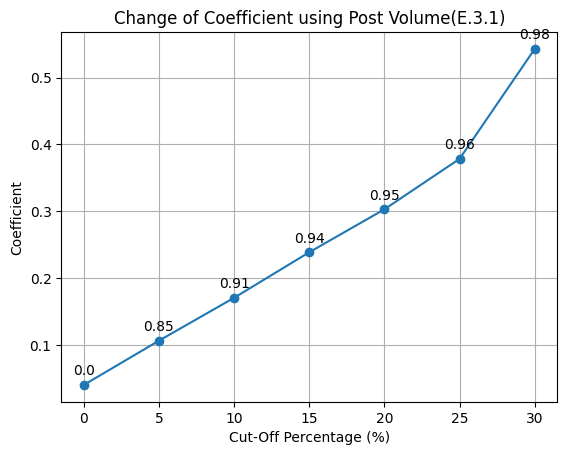

In [99]:
# Visualization
fig, ax = plt.subplots()
ax.plot(result_vr3['cut_off_percentage'], result_vr3['coef'], marker='o')  # Added a marker for each data point

# Adding title and labels
ax.set_title('Change of Coefficient using Post Volume(E.3.1)')
ax.set_xlabel('Cut-Off Percentage (%)')
ax.set_ylabel('Coefficient')

# Optionally add grid
ax.grid(True)

# Adding labels at the top of each point
for i, txt in enumerate(result_vr3['volume_outlier'].round(2)):
    ax.text(result_vr3['cut_off_percentage'][i], result_vr3['coef'][i]+0.01, txt, ha='center', va='bottom')

# Display the plot
plt.show()

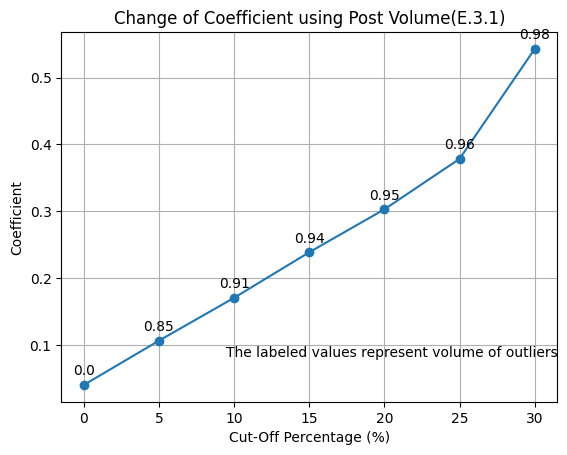

In [146]:
# Visualization
fig, ax = plt.subplots()
line, = ax.plot(result_vr3['cut_off_percentage'], result_vr3['coef'], marker='o', label='Coefficient')  # Added label for legend

# Adding title and labels
ax.set_title('Change of Coefficient using Post Volume(E.3.1)')
ax.set_xlabel('Cut-Off Percentage (%)')
ax.set_ylabel('Coefficient')

# Optionally add grid
ax.grid(True)

# Adding labels at the top of each point
for i, txt in enumerate(result_vr3['volume_outlier'].round(2)):
    ax.text(result_vr3['cut_off_percentage'][i], result_vr3['coef'][i]+0.01, txt, ha='center', va='bottom')

# Adding custom legend
# Adding text message at the top right corner
plt.text(1, 0.15, 'The labeled values represent volume of outliers', 
         horizontalalignment='right', 
         verticalalignment='top', 
         transform=ax.transAxes, 
         fontsize=10)
#ax.legend(handles=legend_elements)

# Display the plot
plt.show()


#### 2.2) Using Bottom-K

In [168]:
# cut-off bottom 0, 1, 3, 5, 10, 20]
cutoff_List = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] #, 2618]
result_vr4 = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val', 'volume_outlier'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = tagTrend.sort_values('pre_share', ascending = False)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    
    # Entropy score
    entropy_Score = []
    for j in range(3, cleansed.shape[1], 2):
        entropy_Score.append(calculate_entropy(cleansed.iloc[:, j]))
    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']],
                                         'volume_outlier': [tagTrend.sort_values('pre_share', ascending = False)[:cutoff_List[i]].pre_share.sum()]})
    result_vr4 = pd.concat([result_vr4, result_model_bottomK], ignore_index = True)

/tmp/ipykernel_1373750/1119018709.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_vr4 = pd.concat([result_vr4, result_model_bottomK], ignore_index = True)


In [169]:
result_vr4

,cut_off_percentage,coef,std_err,P_val,volume_outlier
0,0,0.040476,0.011251,0.000321,0.000000
1,2,0.024226,0.009451,0.010366,0.087987
2,4,0.023024,0.009222,0.012533,0.122905
3,6,0.022432,0.009121,0.013916,0.149756
4,8,0.022579,0.009091,0.013006,0.171323
5,10,0.021474,0.009052,0.017681,0.190610
6,12,0.021101,0.008914,0.017925,0.209180
7,14,0.021121,0.008891,0.017526,0.225770
8,16,0.020966,0.008877,0.018184,0.241795
9,18,0.020562,0.008879,0.020570,0.254997


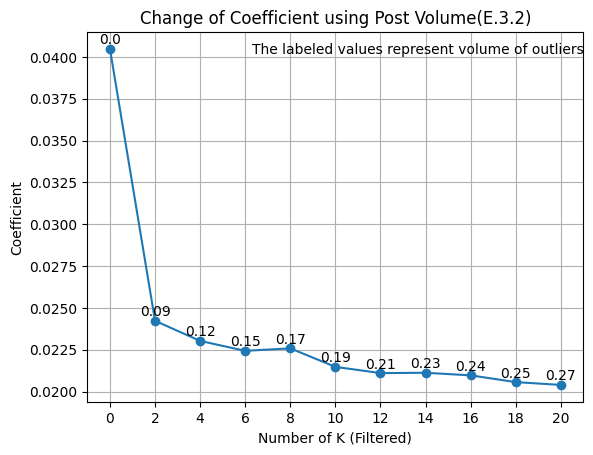

In [170]:
vis_coeff(result_vr4)

### Further Experience

In [171]:
cutoff_List = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30] #, 2618]
result_vr5 = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val', 'volume_outlier'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = tagTrend.sort_values('pre_share', ascending = False)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    
    # Entropy score
    entropy_Score = []
    for j in range(3, cleansed.shape[1], 2):
        entropy_Score.append(calculate_entropy(cleansed.iloc[:, j]))
    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']],
                                         'volume_outlier': [tagTrend.sort_values('pre_share', ascending = False)[:cutoff_List[i]].pre_share.sum()]})
    result_vr5 = pd.concat([result_vr5, result_model_bottomK], ignore_index = True)

/tmp/ipykernel_1373750/3591143014.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_vr5 = pd.concat([result_vr5, result_model_bottomK], ignore_index = True)


In [172]:
result_vr5

,cut_off_percentage,coef,std_err,P_val,volume_outlier
0,0,0.040476,0.011251,0.000321,0.000000
1,2,0.024226,0.009451,0.010366,0.087987
2,4,0.023024,0.009222,0.012533,0.122905
3,6,0.022432,0.009121,0.013916,0.149756
4,8,0.022579,0.009091,0.013006,0.171323
5,10,0.021474,0.009052,0.017681,0.190610
6,12,0.021101,0.008914,0.017925,0.209180
7,14,0.021121,0.008891,0.017526,0.225770
8,16,0.020966,0.008877,0.018184,0.241795
9,18,0.020562,0.008879,0.020570,0.254997


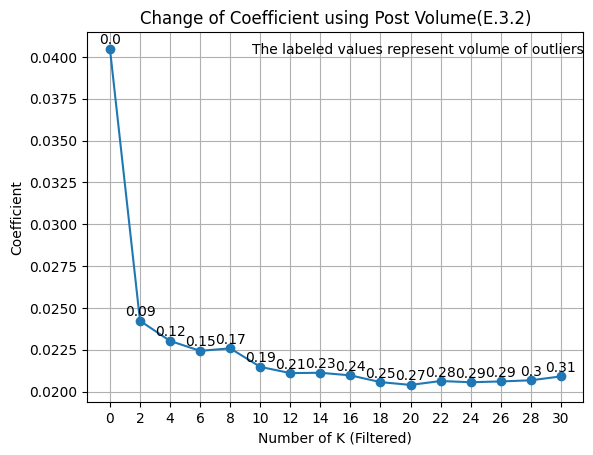

In [173]:
vis_coeff(result_vr5)

In [165]:
cutoff_List = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
result_vr6 = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val', 'volume_outlier'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = tagTrend.sort_values('pre_share', ascending = False)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    
    # Entropy score
    entropy_Score = []
    for j in range(3, cleansed.shape[1], 2):
        entropy_Score.append(calculate_entropy(cleansed.iloc[:, j]))
    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']],
                                         'volume_outlier': [tagTrend.sort_values('pre_share', ascending = False)[:cutoff_List[i]].pre_share.sum()]})
    result_vr6 = pd.concat([result_vr6, result_model_bottomK], ignore_index = True)

/tmp/ipykernel_1373750/3652269614.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_vr6 = pd.concat([result_vr6, result_model_bottomK], ignore_index = True)


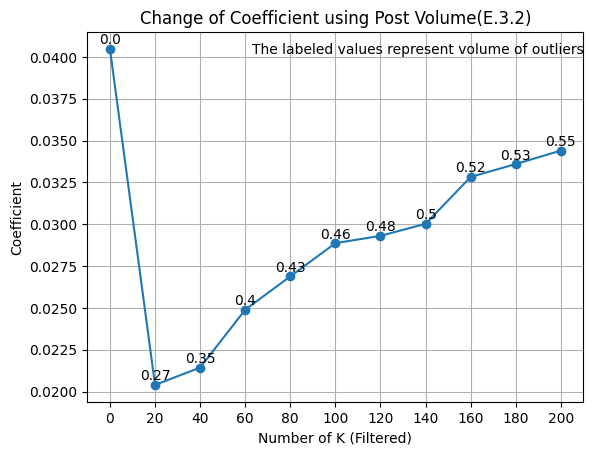

In [166]:
vis_coeff(result_vr6)